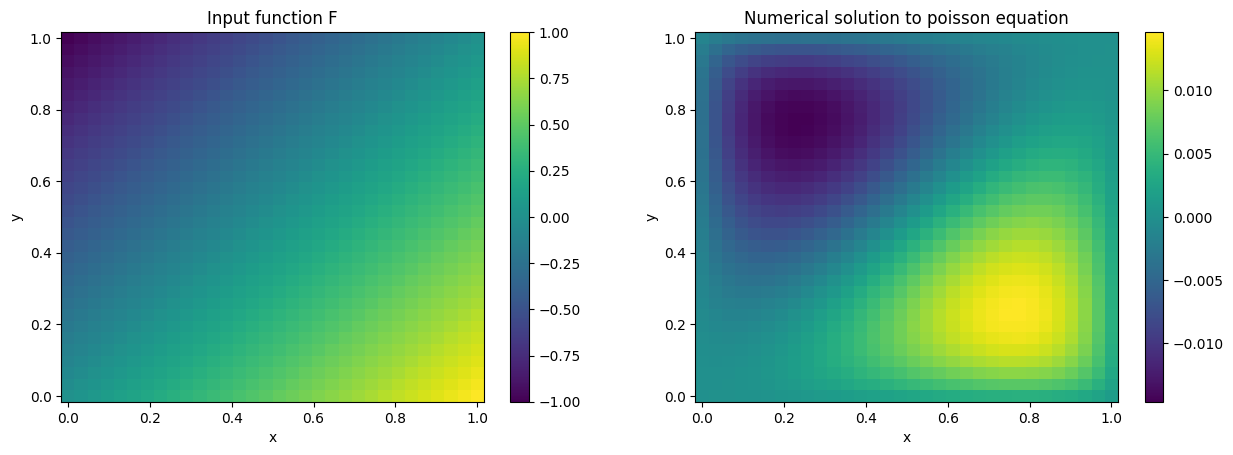

torch.Size([1, 1, 32, 32])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X - Y
#F = np.abs(X-0.5)
#F = X**2 + Y**2
#F = X*Y



#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:

import matplotlib.pyplot as plt
import sys, os

#from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss

import torch.nn.functional as F

from models.FNO_bayesian import FNO2D_Bayesian
from data_transforms.positional_embedding import PositionalEmbedding2D
from losses.nll import NLL


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

cuda


In [7]:
model = FNO2D_Bayesian(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

a = 1
if a == 1:
    state_dict = torch.load("checkpoints_new/model_state.pt")
    model.load_state_dict(state_dict)
    model.to(device)



Our model has 4803394 parameters.


In [4]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3,weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma = 0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# Creating the losses

train_loss = NLL

sys.stdout.flush()

In [5]:
from data_transforms.minmaxscaler_individual import min_max_scale
x_train = torch.load('../../data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)
##x_train = min_max_scale(x_train)
#y_train = min_max_scale(y_train)


grid_boundaries = [[0,1],[0,1]]

x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )


d:\University-local\Imperial\Term_3\Project\.venv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
#test set
x_test = torch.load('../../data_poisson/dirichlet_test_100_32_x.pt').clone().type(torch.FloatTensor)
y_test = torch.load('../../data_poisson/dirichlet_test_100_32_y.pt').clone().type(torch.FloatTensor)
y_test = y_test.unsqueeze(1)
#x_test = min_max_scale(x_test)
#y_test = min_max_scale(y_test)


x_test = PositionalEmbedding2D([[0,1],[0,1]])(x_test)


test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


eval_loss = train_loss

In [7]:
from callbacks.checkpointcallback import CheckpointCallback
from callbacks.loggercallback import LoggerCallback

save_dir = "./checkpoints_new"

ckpt = CheckpointCallback(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallback(save_dir=save_dir)

from training.trainer import Trainer
trainer = Trainer(model=model, n_epochs=301,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [8]:

trainer.train(train_loader=train_loader,
              test_loaders=test_loader,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Train Epoch: 0 	Loss: -1.316076
Test set: Average loss: -2.2952

Train Epoch: 1 	Loss: -2.301639
Test set: Average loss: -2.8113

Train Epoch: 2 	Loss: -2.658497
Test set: Average loss: -3.0503

Train Epoch: 3 	Loss: -2.674054
Test set: Average loss: -3.1200

Train Epoch: 4 	Loss: -2.793651
Test set: Average loss: -2.9387

Train Epoch: 5 	Loss: -3.005397
Test set: Average loss: -3.3235

Train Epoch: 6 	Loss: -2.739994
Test set: Average loss: -3.3988

Train Epoch: 7 	Loss: -3.447501
Test set: Average loss: -3.5383

Train Epoch: 8 	Loss: -3.432105
Test set: Average loss: -3.6685

Train Epoch: 9 	Loss: -2.360256
Test set: Average loss: -2.9707

Model saved at epoch 10.
Train Epoch: 10 	Loss: -3.284216
Test set: Average loss: -3.5104

Train Epoch: 11 	Loss: -3.658355
Test set: Average loss: -3.8773

Train Epoch: 12 	Loss: -3.146668
Test set: Average loss: -3.8373

Train Epoch: 13 	Loss: -3.553475
Test set: Average loss: -3.6746

Train Epoch: 14 	Loss: -3.834835
Test set: Average loss: -4.0

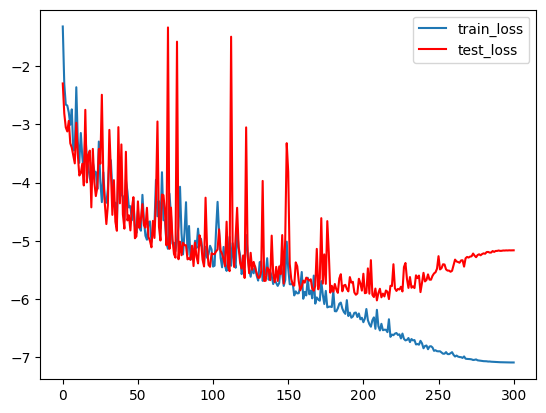

In [8]:
import pandas as pd
losses = pd.read_csv("./checkpoints_new/loss.csv")



plt.plot(np.arange(0,len(losses),1),losses["Train Loss"],"-",label="train_loss")
plt.plot(np.arange(0,len(losses),1),losses["Test Loss"],"-r",label="test_loss")
plt.legend()
plt.show()

tensor(5377.1311, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
tensor(0.2382, device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)


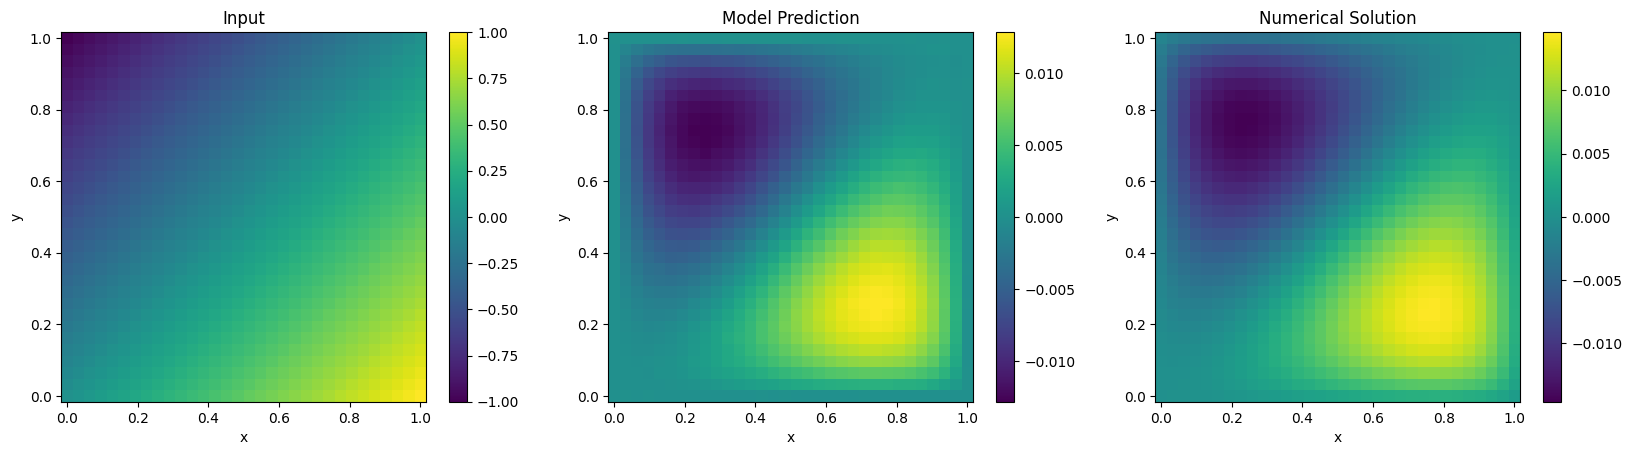

In [9]:
#prediction time
model.eval()
sample = torch.load("../finput.pt").clone().type(torch.FloatTensor) 
#sample = min_max_scale(sample)


#preprocessing
sample = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample).to(device) 



out = model(sample)

U = torch.tensor(U).to(device)


def NLL_2(mean, log_var, targets):
    # Ensure positive variance using the softplus function
    var = torch.exp(log_var) + 1e-8
    nll_data = 0.5 * ((targets - mean) ** 2 / var)
    nll_var = 0.5 * torch.log(var)
    nll = nll_var + nll_data
    #prior
    prior = torch.distributions.Gamma(
        torch.tensor(1).to(mean.device),
        torch.tensor(1).to(mean.device)
    )
    log_prior = prior.log_prob(1./var)
    total_nll = nll - 0.0001*log_prior
    return var

var_unseen = NLL_2(*out,U)

print(train_loss(*out,U))




actual_sample = torch.normal(out[0],torch.sqrt(torch.exp(out[1])))
print(LpLoss(d=2, p =2)(actual_sample.to(device),U))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

fig0 = axs[0].pcolormesh(X,Y,sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Input")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,U.cpu())
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
tensor(-5.6373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0139, device='cuda:0', grad_fn=<SqueezeBackward0>)


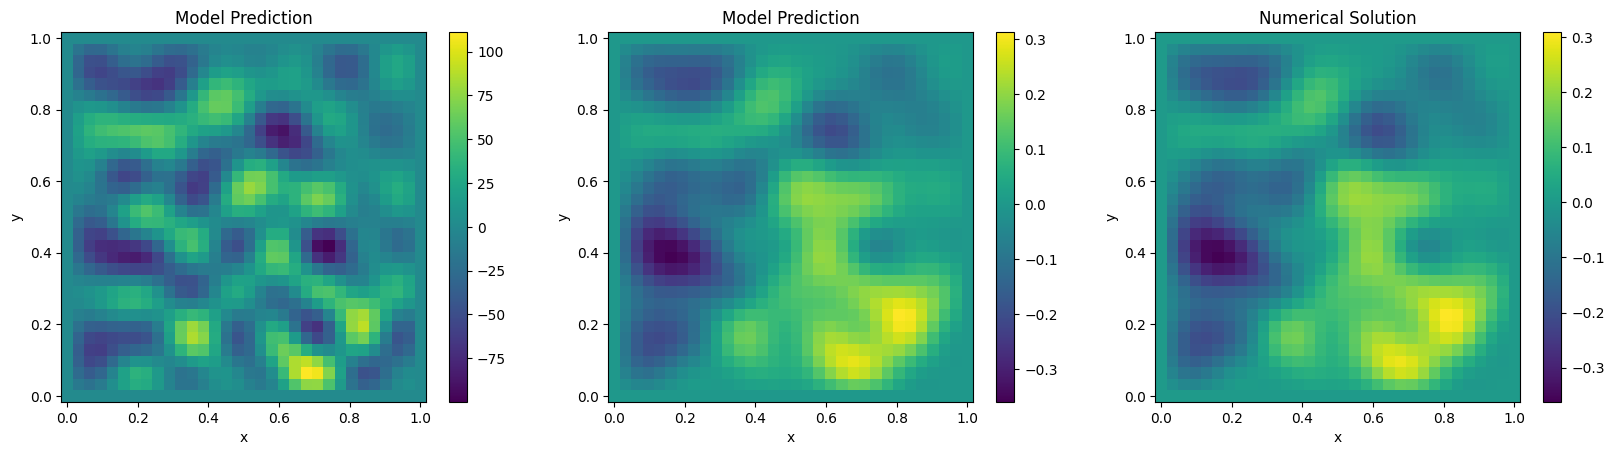

In [12]:
#prediction time
i = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)

#preprocessing
out = model(sample)
print(out[0].shape)


def NLL_2(mean, log_var, targets):
    # Ensure positive variance using the softplus function
    var = torch.exp(log_var) + 1e-8
    nll_data = 0.5 * ((targets - mean) ** 2 / var)
    nll_var = 0.5 * torch.log(var)
    nll = nll_var + nll_data
    #prior
    prior = torch.distributions.Gamma(
        torch.tensor(1).to(mean.device),
        torch.tensor(1).to(mean.device)
    )
    log_prior = prior.log_prob(1./var)
    total_nll = nll -log_prior
    return var




var_seen = NLL_2(*out,test_loader.dataset[i][1].to(device))

print(var_seen.shape)


print(train_loss(*out,test_loader.dataset[i][1].to(device)))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




actual_sample = torch.normal(out[0],torch.sqrt(torch.exp(out[1])))
print(LpLoss(d=2, p =2)(actual_sample,test_loader.dataset[i][1].to(device)))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

fig0 = axs[0].pcolormesh(X,Y,test_loader.dataset[i][0].unsqueeze(0).to(device)[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,test_loader.dataset[i][1].unsqueeze(0)[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


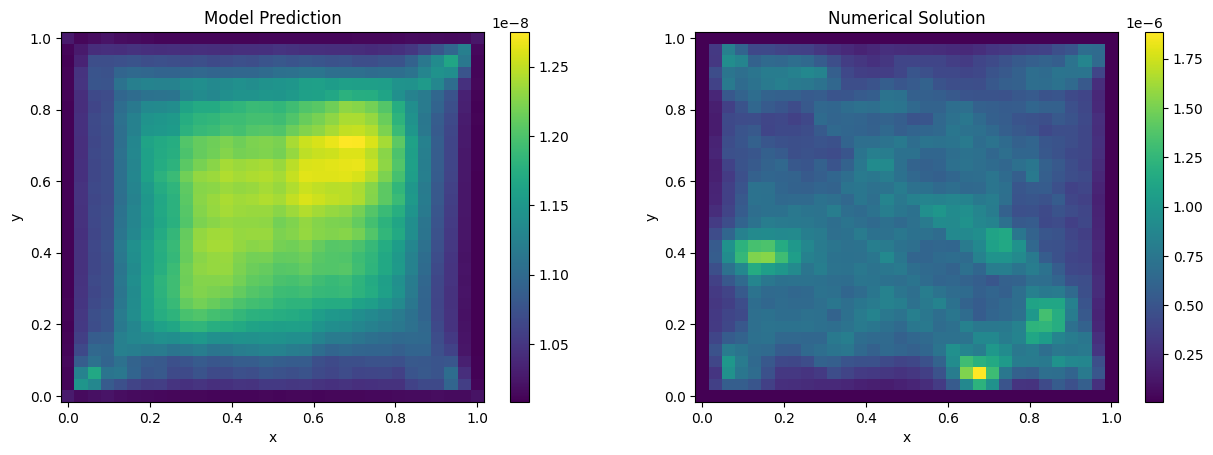

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,var_unseen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,var_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()

In [14]:
(var_unseen<var_seen).sum()/torch.numel(var_seen)*100
 

tensor(100., device='cuda:0')

In [24]:
var_unseen[0,0,10:16,10:16]

tensor([[1.2257e-08, 1.2256e-08, 1.2266e-08, 1.2183e-08, 1.2094e-08, 1.2067e-08],
        [1.2293e-08, 1.2326e-08, 1.2327e-08, 1.2219e-08, 1.2146e-08, 1.2124e-08],
        [1.2276e-08, 1.2328e-08, 1.2338e-08, 1.2241e-08, 1.2185e-08, 1.2190e-08],
        [1.2335e-08, 1.2394e-08, 1.2393e-08, 1.2315e-08, 1.2271e-08, 1.2291e-08],
        [1.2320e-08, 1.2369e-08, 1.2383e-08, 1.2332e-08, 1.2336e-08, 1.2338e-08],
        [1.2220e-08, 1.2273e-08, 1.2331e-08, 1.2308e-08, 1.2303e-08, 1.2294e-08]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [25]:
var_seen[0,0,10:16,10:16]

tensor([[1.4390e-06, 1.3629e-06, 1.5971e-06, 1.4407e-06, 1.4341e-06, 1.1879e-06],
        [1.3949e-06, 1.4172e-06, 1.4632e-06, 1.5186e-06, 1.4892e-06, 1.2768e-06],
        [1.3610e-06, 1.3010e-06, 1.4732e-06, 1.2591e-06, 1.4085e-06, 1.3191e-06],
        [1.1773e-06, 1.2626e-06, 1.1402e-06, 1.3197e-06, 1.4263e-06, 1.2230e-06],
        [1.2029e-06, 1.2562e-06, 1.4954e-06, 1.5451e-06, 1.3922e-06, 1.2185e-06],
        [1.1301e-06, 1.5584e-06, 1.7510e-06, 1.5356e-06, 1.3450e-06, 1.0669e-06]],
       device='cuda:0', grad_fn=<SliceBackward0>)